# Protein Docking Bcl-2-Bax Complex with Genistein Compound
This study has the goal to test common tools and libraries to perform molecular docking and dynamics simulations. We had selected Bcl2-Bax complex and Genistein compound to perform a molecular docking and molecular dynamics simulation.

## Python libraries

In [3]:
# Import libraries
from pymol import cmd         # class with the Pymol functions
from IPython import display   # To display images in notebooks
from PIL import Image         # To crop images
#import nglview                # Viewer for molecular structure 
#import ipywidgets             # For arrange figures

## User functions

In [5]:
## Function to create an image from a pdb file
def createImage (pdb, palette="blue_white_red"):
    imgName = "images/%s.png" % pdb.split(".")[0]
    #cmd.spectrum ("chain", palette)
    #cmd.color (palette)
    cmd.png (imgName, ray=1)
    image = Image.open(imgName)
    cropped = image.crop(image.getbbox())
    cropped.save(imgName)
    return (imgName)

## Show affinities from resulting docking pdbqt file 
def showAffinities (dockFilename):
    n=1
    lines = open (dockFilename).readlines()
    print ("%10s %20s %20s %20s" % ("Mode", "Affinity(kcal/mol)", "RMSD l.b", "RMSD u.b"))
    for l in lines:
        if "RESULT" in l:
            values = l.split(":")[1].split()
            print ("%10s %20s %20s %20s" % tuple([n]+values))
            n+=1

# Function to add a prefix to a filename
def addLabel (filename, prefix):
    name = filename.split (".")[0]
    ext  = filename.split (".")[1]
    newName = "%s_%s.%s" % (name, prefix, ext)
    return (newName)

## Molecules
Bcl-2 Bax complex (PDB: 2xa0) contains for chains:
- Bcl-2: chain A and B
- Bax  : chain C and D

## Select receptor
- Bcl-2 alone (chain A) will be used for docking study.
- All the heteroatoms and Bax peptide will be removed from the coordinate file, 

In [10]:
# Initials
RECEPTOR  = "inputs/protein.pdb"

 Ray: render time: 0.99 sec. = 3634.2 frames/hour (4.02 sec. accum.).


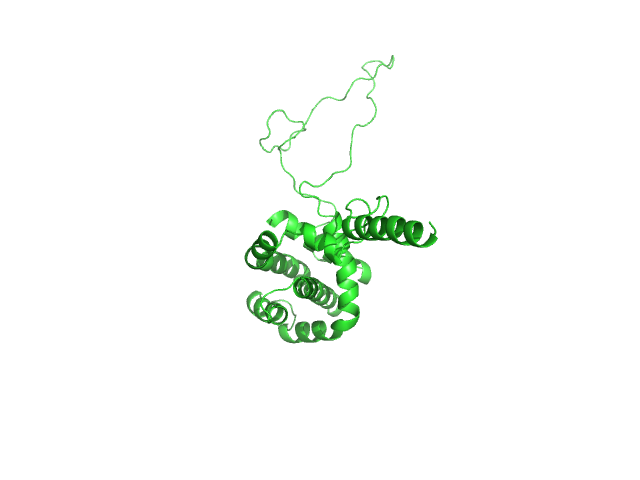

In [15]:
# Load PDB and remove chain B,C,D and HETATM
cmd.load (RECEPTOR)
cmd.save ("images/protein.png")
display.Image ('images/protein.png')

## Select ligand compound
Genistein ligand (PDB: GEN) in SDF format from PDB.

ReadMOLFile-Error: bad atom count
 Ray: render time: 0.12 sec. = 31036.3 frames/hour (4.25 sec. accum.).


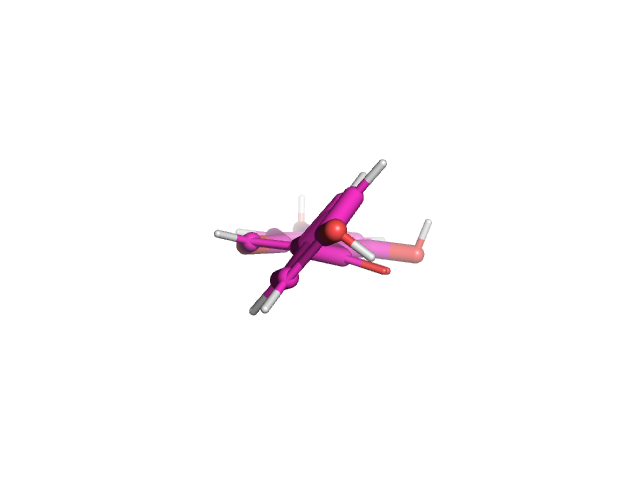

In [22]:
LIGAND = "inputs/GEN_ideal.sdf"
cmd.delete ("all")
cmd.load (LIGAND)
cmd.save ("images/ligand.png")
display.Image ('images/ligand.png')

## Preparing the ligand
Three steps:
1. Adding hydrogen atoms.
2. Running energy minimization. We are using a Pymol plugin called "optimize" for this minimization. The plugin uses the chemical toolbox OpenBabel. The parameters for the minimization are:
    - forcefield="MMFF94s" (https://open-babel.readthedocs.io/en/latest/Forcefields/mmff94.html).  The forcefield used to compute the Internal Energy.
    - method="conjugate gradients". The method used to find the local minimum. Available options are "conjugate gradients" and "steepest descent".
    - nsteps=500. Number of iteration steps during the minimization.
    - conv=0.0001. Criteria used to judge minimization convergence.
    - cutoff=False. Control if cut-off are used or not to compute non-bonded interactions.
    - cut_vdw=6.0. If cutoff is True, then this parameter sets the distance (in Angstroms) beyond which two atoms do not interact through Van der Waals forces.
    - cut_elec=8.0. If cutoff is True, then this parameter sets the distance (in Angstroms) beyond which two atoms do not interact through electrostatic forces.
- Running ligand preparation script on minimized ligand. This preparation involves (Huey2011):
    - Adding partial atomic charges to ligand, and
    - Making atoms conform to AutoDock atom format
    - Describing rotatable bonds in the ligand (AutoDock uses the idea of a torsion tree in which the rigid core of the molecule is a ‘root’, and the flexible parts are ‘branches’ that emanate from the root)
    - Writing ligand in PDBQT format that includes special keywords recognized by AutoDock to stablish this torsion tree. 

In [33]:
import optimize as opt   # Minimize function   
import pymol.cmd as cmd  # Pymol functions

LIGAND = "inputs/GEN_ideal.sdf"
# Clean pymol environment
cmd.delete ("all")

# Load ligand
cmd.load (LIGAND, "ligand")

# Add hydrogens using Pymol
cmd.h_add ("ligand")

# Energy minimization
opt.minimize ("ligand")

# Run prepare script
ligandPrep = "outputs/ligand_PREP.pdbqt"
!mk_prepare_ligand.py -i $LIGAND -o $ligandPrep

ReadMOLFile-Error: bad atom count
#########################################
The Energy of ligand is    36.32 kcal/mol       
#########################################


## Preparing the receptor
For this step we will use the AutoDock script "prepare_receptor4.py" that includes the following actions:
- Building of bonds and addition of hydrogens 
- Addition of gasteiger charges
- Merging of charges and removing of non-polar hydrogens
- Merging of charges and removing of lone pairs
- Removing of water residues
- Removing of chains composed entirely of residues of types other than the standard 20 amino acids,

In [34]:
# Load libraries
import pymol.cmd as cmd  # Pymol functions

receptorPrep = "outputs/receptor_PREP.pdbqt"
# Call the prepare receptor script
!bin/prepare_receptor4.py -r $RECEPTOR -o $receptorPrep -A bonds_hydrogens

adding gasteiger charges to peptide


## Box definition
To define the grid space for the docking, we will use a PyMOL Plugin for calculating docking box for AutoDock and AutoDock Vina. The box can be set using any custom Pymol selection as a ligand, a residue, a set of residues, atom(s), and pseudoatom(s).

*********AutoDock Vina Binding Pocket*********
--center_x 3.1 --center_y 1.3 --center_z -24.9 --size_x 53.2 --size_y 83.9 --size_z 92.0

*********AutoDock Grid Option*********
npts 142 223 245 # num. grid points in xyz
spacing 0.375 # spacing (A)
gridcenter 3.093 1.348 -24.917 # xyz-coordinates or auto

*********LeDock Binding Pocket*********
Binding pocket
-23.5 29.7
-40.6 43.3
-70.9 21.1

BoxCode(box_6690) = showbox -23.5, 29.7, -40.6, 43.3, -70.9, 21.1
 Ray: render time: 0.90 sec. = 4014.9 frames/hour (23.04 sec. accum.).


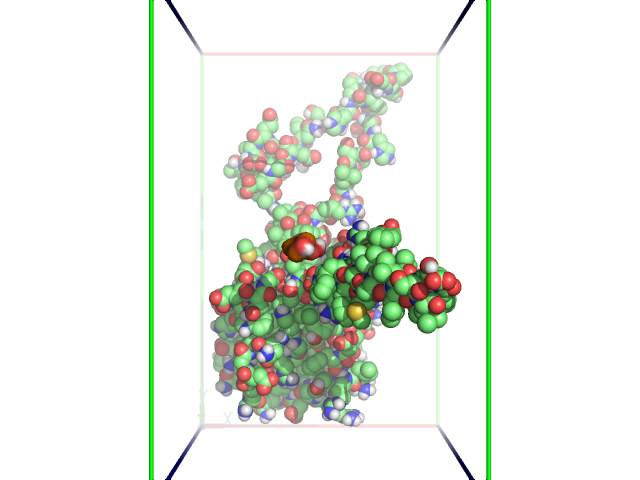

In [50]:
import pymol.cmd as cmd  # Pymol functions
import GetBox as gb
from IPython import display   # To display images in notebooks

# Clean Pymol environment
cmd.delete ("all")

# Load receptor and ligand
LIGAND_PREP   = "outputs/ligand_PREP.pdbqt"
RECEPTOR_PREP = "outputs/receptor_PREP.pdbqt"
cmd.load (LIGAND_PREP, "ligand")
cmd.load (RECEPTOR_PREP, "receptor")

cmd.hide ("all")
cmd.show ("ribbon",)
cmd.show("surface", "ligand")
pocket = gb.getbox(selection="receptor",extending=5.0)

import json
with open ("outputs/pocket.txt", "w") as pfile:
    pfile.write (json.dumps (pocket, indent=2))

cmd.png ("outputs/box.png")
display.Image ("outputs/box.png")

In [51]:
print (pocket)

{'minX': -40.60200119018555, 'minZ': -70.927001953125, 'maxX': 29.718000411987305, 'maxY': 43.29899978637695, 'maxZ': 21.093000411987305, 'centerX': 3.0930004119873047, 'centerY': 1.3484992980957031, 'centerZ': -24.917000770568848, 'sizeX': 53.25, 'sizeY': 83.9010009765625, 'sizeZ': 92.0200023651123}


## Blind docking
In Autodock Vina, parameter of binding energy has been used to determine which ligand that has stable complex interaction with protein (e.g enzyme). And more negative value or lower binding affinity, the more stable ligand-receptor we get. 

In [52]:
from vina import Vina   # For docking
import json as js       # To read json file with pocket parameters
import wurlitzer as wl  # To capture console output

pocket = js.load (open ("outputs/pocket_head.txt"))

v = Vina(sf_name='vina')

v.set_receptor (RECEPTOR_PREP)
v.set_ligand_from_file (LIGAND_PREP)

v.compute_vina_maps(center=[pocket['centerX'], pocket['centerY'], pocket['centerZ']], 
                    box_size=[pocket['sizeX'], pocket['sizeY'], pocket['sizeZ']])

print ("Doking the ligand...")
v.dock(exhaustiveness=64, n_poses=20)    
v.write_poses('outputs/output-vina-poses.pdbqt', n_poses=20, overwrite=True)


Computing Vina grid ... Doking the ligand...
done.
Performing docking (random seed: -1648211133) ... 
0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************


## Binding affinities and RMSD values of calculated poses

In [38]:
showAffinities ("outputs/output-vina-poses.pdbqt")

      Mode   Affinity(kcal/mol)             RMSD l.b             RMSD u.b
         1               -7.659                0.000                0.000
         2               -7.395                1.690                2.441
         3               -7.385                2.284                7.014
         4               -7.349                3.222                3.673
         5               -7.335                1.927                2.262
         6               -7.249                1.677                6.589
         7               -7.095                1.199                2.560
         8               -6.987                1.598                6.855
         9               -6.727                2.060                7.003
        10               -6.672                2.896                6.233
        11               -6.671                2.168                2.476
        12               -6.669                1.408                6.778
        13               -6.487       

# Selection of best ligand-protein complex

<img src='images/protein_ligand_pose01.png' style='float: center;width:50%'></img>